In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.datasets import make_regression
from formulaic import Formula

import matplotlib.pyplot as plt

In [ ]:
# Si necesitan instalar algún paquete
#pip install gapminder
#!pip install formulaic

## Colinealidad y explosión de coeficientes

Para cada una de los conjuntos de datos $A$ y $B$, calcular los coeficientes de regresión por mínimos cuadrados al ajustar la variable $y$.

In [2]:
X_A = np.array([[1], [0.001], [0.001]])
X_B = np.array([[1, 1.001], [0.001, 0.001], [0.001, 0.001]])
y = np.array([1,0,0])
display(X_A)
display(X_B)
display(y)

array([[1.   ],
       [0.001],
       [0.001]])

array([[1.000e+00, 1.001e+00],
       [1.000e-03, 1.000e-03],
       [1.000e-03, 1.000e-03]])

array([1, 0, 0])

In [3]:
# Modelo A
modeloA = linear_model.LinearRegression(fit_intercept = False) 
modeloA.fit(X_A, y)
modeloA.coef_

array([0.999998])

In [4]:
# Modelo B
modeloA = linear_model.LinearRegression(fit_intercept = False) 
modeloA.fit(X_B, y)
modeloA.coef_

array([-1000.,  1000.])

Da números muy grandes, lo cual es un problema

# Mínimos cuadrados regularizados

Consideramos datos de los precios de viviendas en distintos barrios de Boston. Queremos predecir el precio en función de datos demográficos de cada barrio.

In [7]:
data = pd.read_csv("D:\Anibal\Desktop\Agus Facultad\LABO DATOS\Archivos\BostonHousing.csv")
data.head()

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Aníbal\AppData\Local\Temp\ipykernel_11424\3456862793.py:1: SyntaxWarning: invalid escape sequence '\A'
  data = pd.read_csv("D:\Anibal\Desktop\Agus Facultad\LABO DATOS\Archivos\BostonHousing.csv")


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Primero, modelo lineal

In [8]:
# Consideramos primero un modelo lineal con todas las variables
formula = 'medv ~ crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b'
y, X =  Formula(formula).get_model_matrix(data)

In [9]:
X

,Intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,b
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,396.90
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,396.90
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,392.83
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,394.63
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,396.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1.0,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,391.99
502,1.0,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,396.90
503,1.0,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,396.90
504,1.0,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,393.45


In [11]:
y

,medv
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


In [12]:
# Observación: y es una DataFrame (en realidad, una matriz de formulaic)
type(y)

formulaic.model_matrix.ModelMatrix

In [15]:
# Podemos convertirla a serie de Pandas con squeeze().
# Es conveniente para graficar o acceder a los valores de la serie
y = y.squeeze()
type(y)

pandas.core.series.Series

In [17]:
# Separamos en testeo y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Inicializamos el modelo
modeloLineal = linear_model.LinearRegression(fit_intercept = False)  # alpha is the hyperparameter equivalent to lambda

# Entrenamos
modeloLineal.fit(X_train, y_train)

# Predecimos
y_pred = modeloLineal.predict(X_test)

# Evaluamos
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.5f}")

Root Mean Squared Error: 4.92860


Como tenemos datos poblaciones, puede ser útil considerar interacciones (productos entre variables).
Por ejemplo tiene sentido multiplicar cantidad de habitantes por salario promedio.

Sin pensarlo mucho ni mirar mucho las variables, incorporamos las interacciones entre las variables para ver si podemos mejorar el modelo.

In [19]:
# En Formulaic agregamos interacciones con el simbolo *.
# De esta forma se agregan las variables individuales y también los productos.
# Más sobre interaccciones en las próximas clases.
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)-1'
y, X =  Formula(formula).get_model_matrix(data)
y = y.squeeze()
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,...,rad:tax,rad:ptratio,rad:lstat,rad:b,tax:ptratio,tax:lstat,tax:b,ptratio:lstat,ptratio:b,lstat:b
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,...,296,15.3,4.98,396.90,4528.8,1474.08,117482.40,76.194,6072.570,1976.5620
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,...,484,35.6,18.28,793.80,4307.6,2211.88,96049.80,162.692,7064.820,3627.6660
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,...,484,35.6,8.06,785.66,4307.6,975.26,95064.86,71.734,6992.374,1583.1049
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,...,666,56.1,8.82,1183.89,4151.4,652.68,87607.86,54.978,7379.581,1160.2122
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,...,666,56.1,15.99,1190.70,4151.4,1183.26,88111.80,99.671,7422.030,2115.4770


In [20]:
# Separamos en testeo y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression(fit_intercept = True)

# Entrenamos
modeloLineal.fit(X_train, y_train)

# Predecimos
y_pred = modeloLineal.predict(X_test)

# Evaluamos
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.5f}")

Root Mean Squared Error: 3.38172


Logramos una reducción importante del error cuadrático.

**Ejercicio:** Mirando los coeficientes con cuidado, seleccionar cuáles interacciones son importantes, y utilizar las técnicas vistas de selección de modelos, seleccionar un modelo lineal con pocas variables y similar poder explicativo.

Una forma rápida de mirar coeficientes es graficarlos.

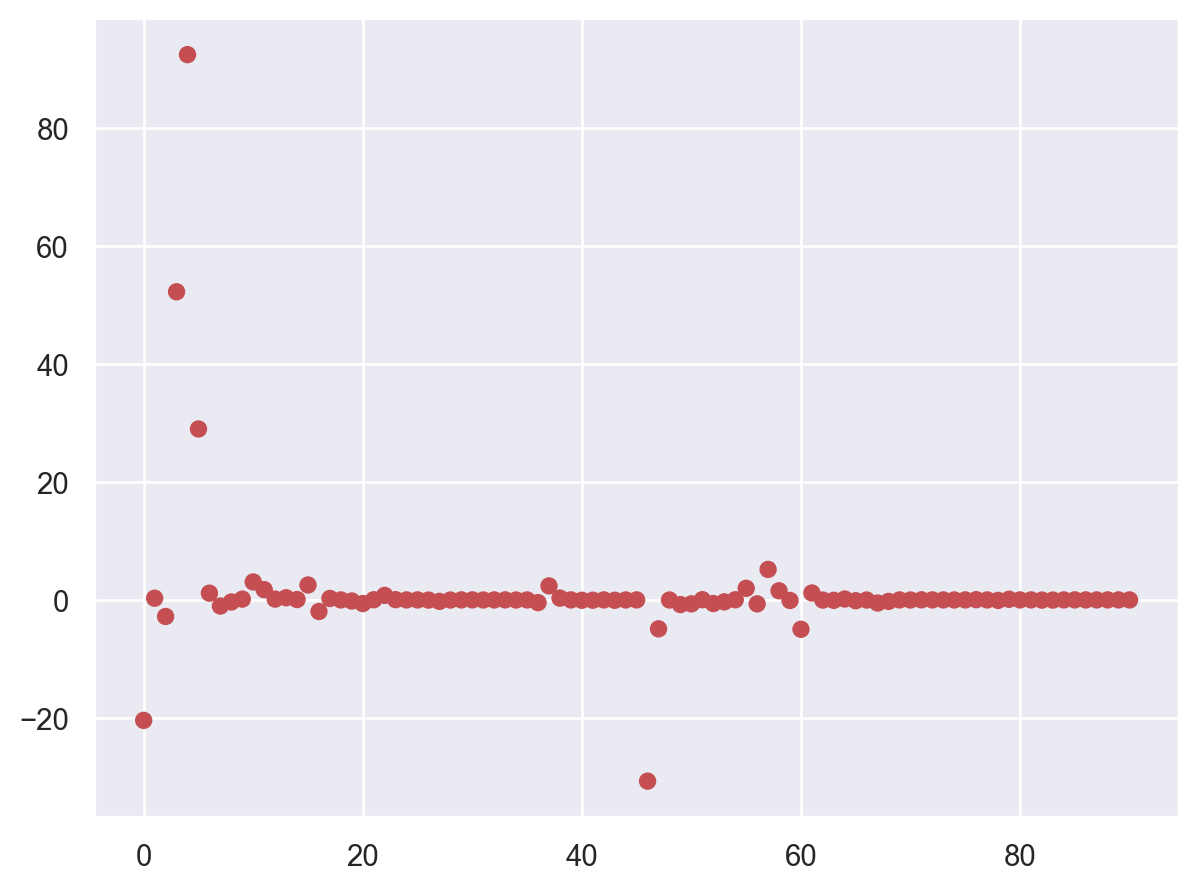

In [22]:
(
    so.Plot(x = np.arange(X.shape[1]))
    .add(so.Dot(color = "r"), y = modeloLineal.coef_)
)

In [23]:
modeloLineal.intercept_

-210.2135928702047

Al introducir tantas variables nuevas, relacionadas con las variables originales, es muy posible que hayamos introducido colinealidad entre las variables.

Es razonable entonces intentar un modelo de mínimos cuadrados regularizados.

# Regresión Ridge

**Paso 1:** Separamos los datos en entrenamiento y testeo.

In [24]:
# Separamos en testeo y entrenamiento
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

In [25]:
# Construimos las matrices X e y para entrenamiento
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b) - 1'
y, X =  Formula(formula).get_model_matrix(df_train)
y = y.squeeze()

**Pregunta:** Que consideran más apropiado:
1. incluir el intecerpt como columna en los datos (y por lo tanto, incluir el coeficiente $\beta_0$ en la penalización de Ridge)
2. excluir el intecerpt como columna en los datos (y por lo tanto, excluir el coeficiente $\beta_0$ en la penalización de Ridge)

<details> <summary>Respuesta (click aquí)</summary>
En general debemos excluir el intercept de la penalización. De esta forma nos aseguramos que al tomar valores grandes de $\alpha$, el modelo se aproxime a la recta constante que mejor aproxima los datos.

Si incluimos $\beta_0$ en la penalidad, al tomar $\alpha$ grande, nuestro modelos se a aproxima a la recta $y=0$, que no aproxima los datos.
</details>

**Paso 2:** Definimos un vector de parámetros a probar

In [27]:
alphas = np.array([0.001, 0.01, 0.1, 0.5, 1, 2, 3])

**Pasos 3 y 4:** Para cada valor de alpha, calculamos el error promedio al realizar validación cruzada de 5 pliegos en los datos de entrenamiento.

In [28]:
# Comenzamos con un valor de alpha fijo
alpha = alphas[0]  # alpha = 0.01

cv = KFold(n_splits=5, random_state=42, shuffle=True)  # 5 pliegos

modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = True)    # Inicializamos un modelo de Regresion Lineal con intercept
rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0

# Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
for train_index, val_index in cv.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
    modeloRidge.fit(X_train,y_train)
    
    y_pred = modeloRidge.predict(X_val)
    rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
    ind = ind + 1

print(f"Mean Squared Error: {rmse.mean():.2f}")

Mean Squared Error: 4.53


Esto lo hicimos para un solor valor de alpha, podemos hacerlo fácilmente para varios valores.

In [ ]:
for alpha in alphas:
    # Inicializamos un modelo de Regresion Lineal sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alfa = {alpha:.5f} el Error Cuadrático Medio es : {rmse.mean():.5f}")

Para alfa = 0.00100 el Error Cuadrático Medio es : 4.68369
Para alfa = 0.01000 el Error Cuadrático Medio es : 4.65189
Para alfa = 0.10000 el Error Cuadrático Medio es : 4.57107
Para alfa = 0.50000 el Error Cuadrático Medio es : 4.54287
Para alfa = 1.00000 el Error Cuadrático Medio es : 4.55213
Para alfa = 2.00000 el Error Cuadrático Medio es : 4.56577
Para alfa = 3.00000 el Error Cuadrático Medio es : 4.57126


El valor óptimo es alpha = 0.5.
En base a los resultados observados agregamos algunos valores de alpha cercanos a 0.5.

In [31]:
alphas = np.array([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3])
error_alphas = np.zeros(len(alphas))

for counter, alpha in enumerate(alphas):  # Truco para tener un contador al recorrer una lista
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alfa = {alpha:.5f} el Error Cuadrático Medio es : {rmse.mean():.5f}")
    error_alphas[counter] = rmse.mean()

Para alfa = 0.00100 el Error Cuadrático Medio es : 4.68369
Para alfa = 0.01000 el Error Cuadrático Medio es : 4.65189
Para alfa = 0.10000 el Error Cuadrático Medio es : 4.57107
Para alfa = 0.20000 el Error Cuadrático Medio es : 4.55118
Para alfa = 0.30000 el Error Cuadrático Medio es : 4.54446
Para alfa = 0.40000 el Error Cuadrático Medio es : 4.54256
Para alfa = 0.50000 el Error Cuadrático Medio es : 4.54287
Para alfa = 0.60000 el Error Cuadrático Medio es : 4.54422
Para alfa = 0.70000 el Error Cuadrático Medio es : 4.54605
Para alfa = 1.00000 el Error Cuadrático Medio es : 4.55213
Para alfa = 2.00000 el Error Cuadrático Medio es : 4.56577
Para alfa = 3.00000 el Error Cuadrático Medio es : 4.57126


Obtuvimos el valor más chico para $\alpha = 0.4$. 

Fijamos este valor y ajustamos el modelo usando todos los datos.

**Importante:** 
1. Los coeficientes de la regresión son **parámetros** y se recalculan utilizando todos los datos.
2. El coeficiente $\alpha$ es un **hiperparámetro**, queda fijo y no se recalcula.

In [32]:
alpha_optimo = 0.4

modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = True)    # Inicializamos un modelo de Regresion Lineal sin intercept
modeloRidge.fit(X,y)

Ridge(alpha=0.4)

Probamos el modelo obtenido en los datos de testeo.

In [33]:
# Construimos las matrices X e y para testeo
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)-1'
y_test, X_test =  Formula(formula).get_model_matrix(df_test)
        
y_pred = modeloRidge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"For alpha = {alpha_optimo:.5f} the Root Mean Squared Error is: {rmse.mean():.5f}")

For alpha = 0.40000 the Root Mean Squared Error is: 3.35602


Obtuvimos un error menor!

Podemos comparar los coeficientes gráficamente:

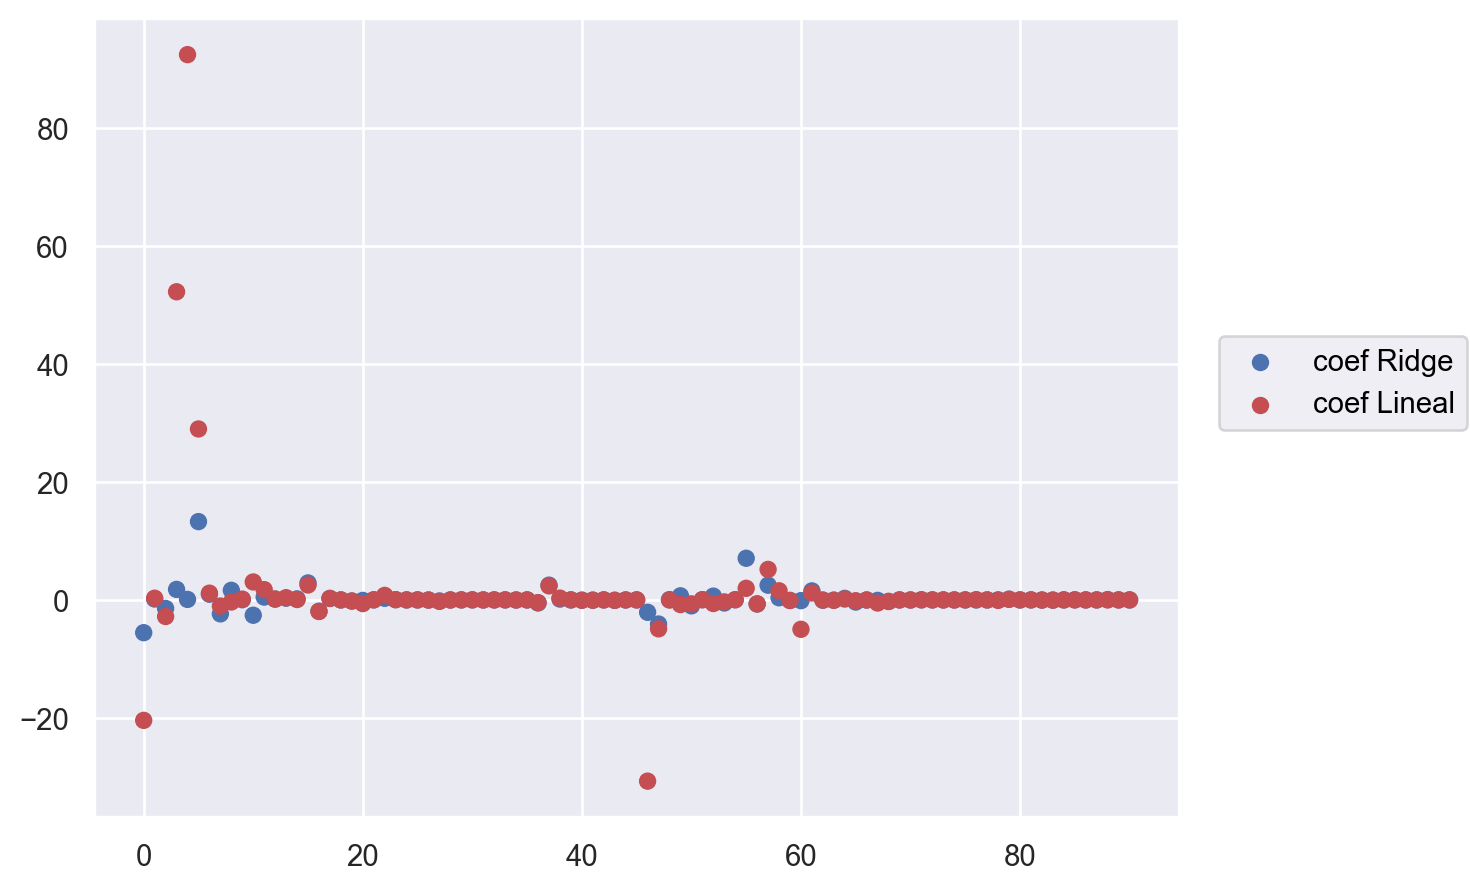

In [37]:
(
    so.Plot(x = np.arange(X.shape[1]))
    .add(so.Dot(color = "b"), y = modeloRidge.coef_, label="coef Ridge")
    .add(so.Dot(color = "r"), y = modeloLineal.coef_, label="coef Lineal")
)

In [35]:
modeloLineal.intercept_

-210.2135928702047

In [38]:
modeloRidge.intercept_

-70.4958245927908

Observamos que en los coeficientes del modelo lineal hay valores positivos altos que parecen cancelarse con valores negativos altos. Esto suele indicar colinealidad en las variables. Al hacer regresión Ridge, reducimos los problemas de la colinealidad

### Curva de errores 
Puede ser instructivo graficar el error en función de alfa.

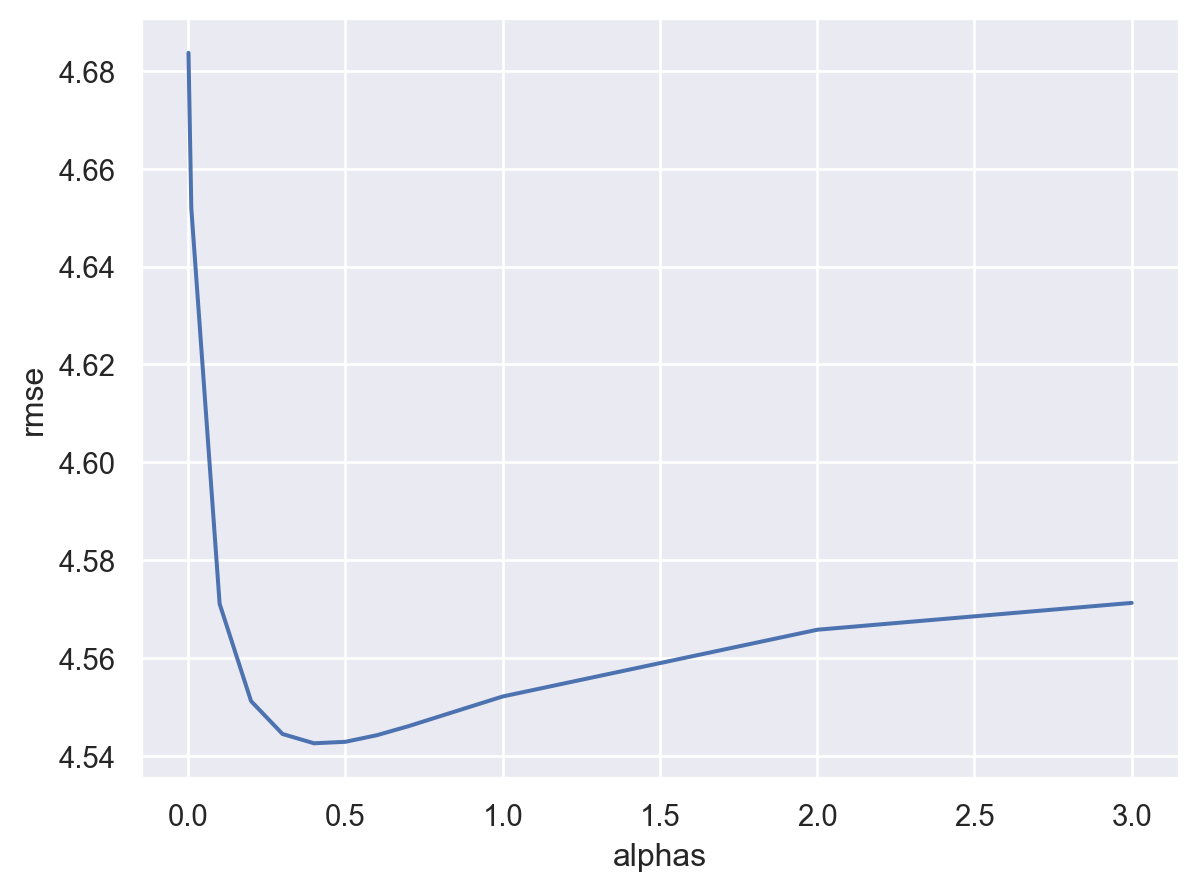

In [43]:
(
    so.Plot(x = alphas, y = error_alphas)
    .add(so.Line(color = "b"))
    .label(x = "alphas", y = "rmse")
)

**Preguntas:**
1. Qué pasa si la curva es decreciente?
2. Qué pasa si la curva es creciente?
3. Qué pasa si alpha = 0?

# Regresión ridge y escalamiento de las variables

Ya vimos que el escalamiento de variables nos puede servir en el modelo lineal para comparar coeficientes del modelo y deducir apropiadamente el peso de cada variable en el modelo.

Sin embargo, el escalamiento no afecta la bondad del modelo. El modelo lineal es invariante por escalamientos lineales de variables.

¿Qué pasa en regresión Ridge? ¿Será invariante por escalamiento de variables?

<details> <summary>Respuesta (click aquí)</summary>
Regresión Ridge NO es invariante por escalamiento. Si algunas variable está en una escala muy alta (por ejemplo medida en pesos) comparada con otras variables (por ejemplo medidas en dólares), el resultado será que las variables en dolares sean más penalizadas que las variables en pesos (porque tendrían en general coeficientes mayores).
</details>

## Caso de estudio: Jugadores de basketball universitario

In [45]:
basketball = pd.read_csv("D:\Anibal\Desktop\Agus Facultad\LABO DATOS\Archivos/CollegeBasketballPlayers2009-2021.csv")
basketball

<>:1: SyntaxWarning: invalid escape sequence '\A'
<>:1: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Aníbal\AppData\Local\Temp\ipykernel_11424\1248122047.py:1: SyntaxWarning: invalid escape sequence '\A'
  basketball = pd.read_csv("D:\Anibal\Desktop\Agus Facultad\LABO DATOS\Archivos/CollegeBasketballPlayers2009-2021.csv")
C:\Users\Aníbal\AppData\Local\Temp\ipykernel_11424\1248122047.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  basketball = pd.read_csv("D:\Anibal\Desktop\Agus Facultad\LABO DATOS\Archivos/CollegeBasketballPlayers2009-2021.csv")


,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
0,DeAndrae Ross,South Alabama,SB,26,29.5,97.3,16.6,42.5,44.43,1.6,...,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,NaN,6.22026
1,Pooh Williams,Utah St.,WAC,34,60.9,108.3,14.9,52.4,54.48,3.8,...,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,NaN,3.94375
2,Jesus Verdejo,South Florida,BE,27,72.0,96.2,21.8,45.7,47.98,2.1,...,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,NaN,10.92680
3,Mike Hornbuckle,Pepperdine,WCC,30,44.5,97.7,16.0,53.6,53.69,4.1,...,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,NaN,6.77427
4,Anthony Brown,Pacific,BW,33,56.2,96.5,22.0,52.8,54.31,8.3,...,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61056,Trey Patterson,Villanova,BE,2,0.3,60.5,19.3,0.0,0.00,0.0,...,16.018200,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,Pure PG,0.00000
61057,Stavros Polatoglou,Northwestern St.,Slnd,4,1.3,28.3,7.1,0.0,0.00,7.0,...,-4.993820,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,C,0.00000
61058,Sandy Ryan,Tulane,Amer,1,0.1,0.0,0.0,0.0,0.00,0.0,...,-1.126810,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,PF/C,0.00000
61059,Ty Larson,Texas Tech,B12,1,0.1,0.0,0.0,0.0,0.00,0.0,...,-2.380750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,PF/C,0.00000


In [46]:
basketball.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61061 entries, 0 to 61060
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   player_name                      61061 non-null  object 
 1   team                             61061 non-null  object 
 2   conf                             61061 non-null  object 
 3   GP                               61061 non-null  int64  
 4   Min_per                          61061 non-null  float64
 5   Ortg                             61061 non-null  float64
 6   usg                              61061 non-null  float64
 7   eFG                              61061 non-null  float64
 8   TS_per                           61061 non-null  float64
 9   ORB_per                          61061 non-null  float64
 10  DRB_per                          61061 non-null  float64
 11  AST_per                          61061 non-null  float64
 12  TO_per            

In [47]:
# Nos quedamos solo con las variables numéricas
basketNumeric = basketball.select_dtypes(include='number')

### Limpieza de datos: datos faltantes
Veamos cuántos datos faltantes hay por columna

In [48]:
with pd.option_context('display.max_rows', None): 
    print(basketball.isna().sum())  # Cantidad de datos faltantes por columna

player_name                            0
team                                   0
conf                                   0
GP                                     0
Min_per                                0
Ortg                                   0
usg                                    0
eFG                                    0
TS_per                                 0
ORB_per                                0
DRB_per                                0
AST_per                                0
TO_per                                 0
FTM                                    0
FTA                                    0
FT_per                                 0
twoPM                                  0
twoPA                                  0
twoP_per                               0
TPM                                    0
TPA                                    0
TP_per                                 0
blk_per                                0
stl_per                                0
ftr             

In [49]:
# Eliminamos primero las columnas con más de 100 datos faltantes
nan_cols = basketNumeric.isna().sum() > 100  # Vector booleano
keep = nan_cols.index[~(nan_cols)] # Lista con los nombres de las columnas para dejar
basketNumeric = basketNumeric[keep] # Seleccionamos solo las columnas en keep

In [50]:
# Verificamos ahora cuantos datos faltantes hay por columna
basketNumeric.isna().sum()

GP              0
Min_per         0
Ortg            0
usg             0
eFG             0
TS_per          0
ORB_per         0
DRB_per         0
AST_per         0
TO_per          0
FTM             0
FTA             0
FT_per          0
twoPM           0
twoPA           0
twoP_per        0
TPM             0
TPA             0
TP_per          0
blk_per         0
stl_per         0
ftr             0
porpag          0
adjoe           0
pfr             0
year            0
pid             0
drtg           45
adrtg          45
dporpag        45
stops          45
bpm            45
obpm           45
dbpm           45
gbpm           45
mp             38
ogbpm          45
dgbpm          45
oreb           38
dreb           38
treb           38
ast            38
stl            38
blk            38
pts            38
Unnamed: 65    45
dtype: int64

In [51]:
# Ahora eliminamos todas las filas con datos faltantes
basketNumericClean = basketNumeric.dropna()
basketNumericClean

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 65
0,26,29.5,97.3,16.6,42.5,44.43,1.6,4.6,15.8,16.3,...,-2.781990,-1.941150,0.1923,0.6154,0.8077,1.1923,0.3462,0.0385,3.8846,6.22026
1,34,60.9,108.3,14.9,52.4,54.48,3.8,6.3,13.6,19.8,...,-0.052263,-0.247934,0.6765,1.2647,1.9412,1.8235,0.4118,0.2353,5.9412,3.94375
2,27,72.0,96.2,21.8,45.7,47.98,2.1,8.0,14.7,15.9,...,1.548230,-0.883163,0.6296,2.3333,2.9630,1.9630,0.4815,0.0000,12.1852,10.92680
3,30,44.5,97.7,16.0,53.6,53.69,4.1,9.4,13.7,23.8,...,-0.342775,-0.393459,0.7000,1.4333,2.1333,1.1000,0.5667,0.1333,4.9333,6.77427
4,33,56.2,96.5,22.0,52.8,54.31,8.3,18.6,8.2,22.7,...,-1.684860,-0.668318,1.4242,3.3030,4.7273,0.8485,0.4545,0.3333,7.5758,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61056,2,0.3,60.5,19.3,0.0,0.00,0.0,0.0,51.1,0.0,...,2.143290,16.018200,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,0.00000
61057,4,1.3,28.3,7.1,0.0,0.00,7.0,0.0,0.0,50.3,...,-7.242230,-4.993820,0.2500,0.0000,0.2500,0.0000,0.0000,0.0000,0.0000,0.00000
61058,1,0.1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,-3.524820,-1.126810,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000
61059,1,0.1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,-1.876040,-2.380750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.00000


Ajutamos primero un modelo lineal sobre todos los datos para predecir la variable pts en función del resto.

In [52]:
y = basketNumericClean["pts"]

In [53]:
X = basketNumericClean.drop(["pts"], axis = 1)

In [54]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X, y)

# Predicciones
y_pred = modeloLineal.predict(X)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")

Raíz del Error Cuadrático Medio: 0.53186


In [55]:
# R cuadrado
r2_score(y, y_pred)

0.9884454952158965

In [56]:
# Coeficientes
modeloLineal.coef_

array([ 9.49041919e-04, -1.44037029e-02, -5.84160913e-04,  5.34806512e-02,
        1.36912337e-03,  3.02023783e-03, -1.53128582e-02, -1.07051894e-02,
       -6.16837806e-03,  1.63511499e-03,  1.11272335e-02,  9.48488250e-03,
        6.89157491e-02,  3.92352065e-02,  6.43518234e-03, -9.72187670e-02,
        4.78754956e-02,  9.28104743e-03, -9.08937931e-03,  2.72161818e-04,
       -6.66128222e-02, -8.83261583e-04,  5.61388150e-01, -7.47118122e-03,
        2.02966123e-02,  3.45374357e-02, -1.70531358e-07, -3.69712771e-02,
        1.39239764e-02, -3.64690277e-01, -4.50866412e-02, -2.99056743e+02,
        2.99095398e+02,  2.99040561e+02, -1.60810692e+02,  2.44914258e-01,
        1.60839068e+02,  1.60792923e+02,  1.51727316e+01,  1.60172156e+01,
       -1.53952269e+01, -1.53084521e-01,  1.48556757e+00,  5.65646343e-01,
       -9.50049614e-03])

In [57]:
# Graficamos

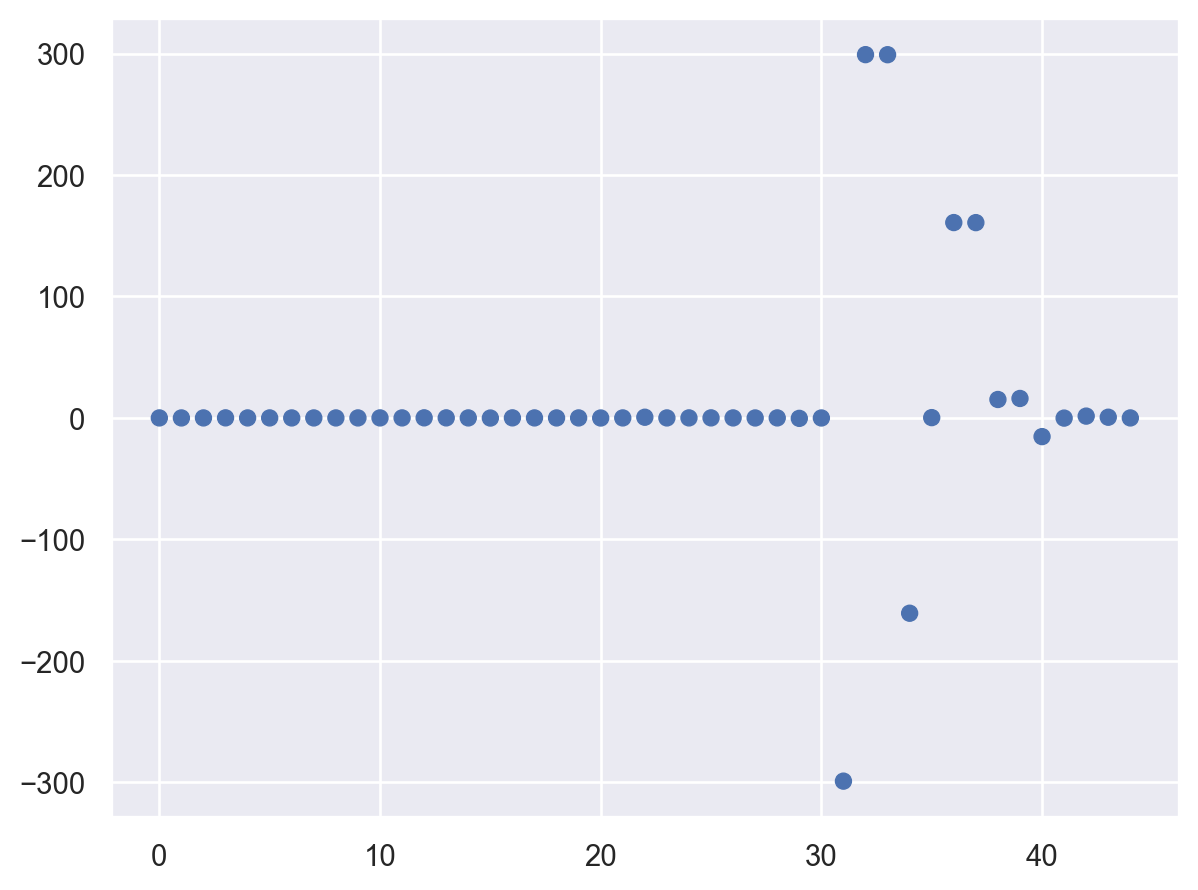

In [58]:
so.Plot(x = np.arange(len(modeloLineal.coef_)), y = modeloLineal.coef_).add(so.Dot())

Observando los coeficientes, hay coeficientes grandes que se cancelan, indicando posible colinealidad, lo que sugiere utilizar regresión Ridge. 

Veamos primero si las variables están en la misma escala.

In [59]:
X.max()

GP                41.00000
Min_per           98.00000
Ortg             834.00000
usg               50.00000
eFG              150.00000
TS_per           150.00000
ORB_per         1576.60000
DRB_per         1385.00000
AST_per          100.00000
TO_per           100.00000
FTM              312.00000
FTA              374.00000
FT_per             1.00000
twoPM            333.00000
twoPA            678.00000
twoP_per           1.00000
TPM              147.00000
TPA              394.00000
TP_per             1.00000
blk_per         1072.00000
stl_per          118.20000
ftr             1000.00000
porpag             8.65819
adjoe            678.94200
pfr              720.00000
year            2021.00000
pid            74254.00000
drtg             131.46100
adrtg            144.68500
dporpag            5.80053
stops            360.57200
bpm              685.31300
obpm             161.99500
dbpm             523.31900
gbpm             269.50800
mp                50.00000
ogbpm            225.48500
d

In [60]:
X.mean()

GP                22.813439
Min_per           37.155609
Ortg              91.688942
usg               18.128626
eFG               44.519525
TS_per            47.605250
ORB_per            5.530615
DRB_per           12.700775
AST_per           10.811866
TO_per            20.236253
FTM               31.935557
FTA               45.692895
FT_per             0.578298
twoPM             40.395329
twoPA             83.106121
twoP_per           0.426923
TPM               15.355503
TPA               44.725133
TP_per             0.227645
blk_per            1.867796
stl_per            1.713325
ftr               37.045425
porpag             0.773659
adjoe             89.163307
pfr                4.217186
year            2015.064984
pid            33580.606425
drtg             103.268935
adrtg            103.418942
dporpag            1.436595
stops             80.832228
bpm               -2.539152
obpm              -1.903434
dbpm              -0.635718
gbpm              -2.537783
mp                16

Vemos que hay mucha diferencia en las escalas de las variables. Para poder comparar mejor los coeficientes, escalamos todas la variables al intervalo [0,1].

Utilizamos el escalamiento estándar. Puede utilizarse también MinMax.

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

# fit_transform calcula los coeficientes de la transformación y la aplica.
X_scaled = scaler.fit_transform(X)
X_scaled


,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,mp,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,Unnamed: 65
0,0.313828,-0.272921,0.181894,-0.244841,-0.109792,-0.180444,-0.428439,-0.760246,0.533650,-0.319877,...,-0.222768,-0.111170,-0.447194,-0.778913,-0.864303,-0.884132,0.102105,-0.390292,-0.584599,0.149641
1,1.101707,0.846482,0.538482,-0.517131,0.428422,0.390680,-0.188638,-0.600704,0.298286,-0.035452,...,0.714578,0.326460,0.060333,-0.119957,-0.426671,-0.343789,0.641735,-0.250600,-0.110154,-0.258218
2,0.412313,1.242194,0.146235,0.588047,0.064177,0.021296,-0.373939,-0.441161,0.415968,-0.352383,...,1.529799,0.583051,-0.130071,-0.183784,0.293573,0.143307,0.760998,-0.102177,-0.677415,0.992864
3,0.707767,0.261826,0.194861,-0.340944,0.493660,0.345786,-0.155938,-0.309773,0.308984,0.289606,...,0.096490,0.279885,0.016714,-0.087976,-0.313033,-0.252214,0.023195,0.079253,-0.356055,0.248898
4,1.003222,0.678928,0.155961,0.620081,0.450168,0.381019,0.301864,0.553634,-0.279428,0.200215,...,0.561975,0.064722,-0.065673,0.897601,0.947158,0.984355,-0.191819,-0.159672,0.126104,-0.964779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61056,-2.049808,-1.313894,-1.011055,0.187620,-2.420305,-2.705323,-0.602840,-1.191950,4.310184,-1.644487,...,-1.454376,0.678452,4.935974,-1.040618,-1.279087,-1.269166,-0.489761,-0.062782,-0.677415,-0.964779
61057,-1.852839,-1.278244,-2.054885,-1.766464,-2.420305,-2.705323,0.160164,-1.191950,-1.156696,2.443112,...,-1.242467,-0.826237,-1.362207,-0.700389,-1.279087,-1.149990,-0.917225,-1.127509,-0.677415,-0.964779
61058,-2.148293,-1.321024,-2.972289,-2.903676,-2.420305,-2.705323,-0.602840,-1.191950,-1.156696,-1.644487,...,-1.501467,-0.230261,-0.203102,-1.040618,-1.279087,-1.269166,-0.917225,-1.127509,-0.677415,-0.964779
61059,-2.148293,-1.321024,-2.972289,-2.903676,-2.420305,-2.705323,-0.602840,-1.191950,-1.156696,-1.644487,...,-1.501467,0.034072,-0.578961,-1.040618,-1.279087,-1.269166,-0.917225,-1.127509,-0.677415,-0.964779


In [62]:
X_scaled.max()

GP               1.791101
Min_per          2.169088
Ortg            24.063565
usg              5.104863
eFG              5.734448
TS_per           5.818914
ORB_per        171.247291
DRB_per        128.788373
AST_per          9.541699
TO_per           6.481951
FTM              7.744375
FTA              6.750788
FT_per           1.553087
twoPM            6.794775
twoPA            7.096325
twoP_per         2.932256
TPM              6.210344
TPA              6.122518
TP_per           4.053103
blk_per        187.553201
stl_per         56.292462
ftr             26.265094
porpag           5.913943
adjoe           18.891157
pfr            162.495033
year             1.582902
pid              1.993325
drtg             2.797940
adrtg            3.766259
dporpag          4.097812
stops            4.329243
bpm             90.685735
obpm            31.491101
dbpm           123.205503
gbpm            32.451510
mp               3.113450
ogbpm           36.484639
dgbpm           23.809904
oreb        

In [63]:
X_scaled.mean()

GP             1.341548e-16
Min_per        5.030803e-17
Ortg           1.714200e-16
usg            4.965589e-16
eFG           -1.397445e-17
TS_per         1.285650e-16
ORB_per       -2.282494e-17
DRB_per       -5.729526e-17
AST_per        2.888054e-17
TO_per        -7.080390e-17
FTM           -2.235913e-17
FTA           -3.726521e-17
FT_per        -4.695416e-16
twoPM         -9.688954e-17
twoPA         -3.726521e-17
twoP_per      -6.428249e-17
TPM           -2.049587e-17
TPA           -5.589781e-17
TP_per        -8.570998e-17
blk_per       -2.142750e-17
stl_per        2.329076e-17
ftr           -8.291509e-17
porpag        -1.490608e-17
adjoe          3.260706e-16
pfr            6.381667e-17
year          -2.943952e-14
pid            2.981217e-17
drtg          -8.240269e-16
adrtg         -2.943952e-16
dporpag        2.981217e-17
stops          3.651991e-16
bpm           -4.285499e-17
obpm           1.490608e-17
dbpm           8.384672e-18
gbpm           3.633358e-17
mp            -2.049

In [ ]:
# Repetimos el modelo lineal

In [64]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression() 

# Entrenamiento
modeloLineal.fit(X_scaled, y)

# Predicciones
y_pred = modeloLineal.predict(X_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53186
R cuadrado: 0.98845


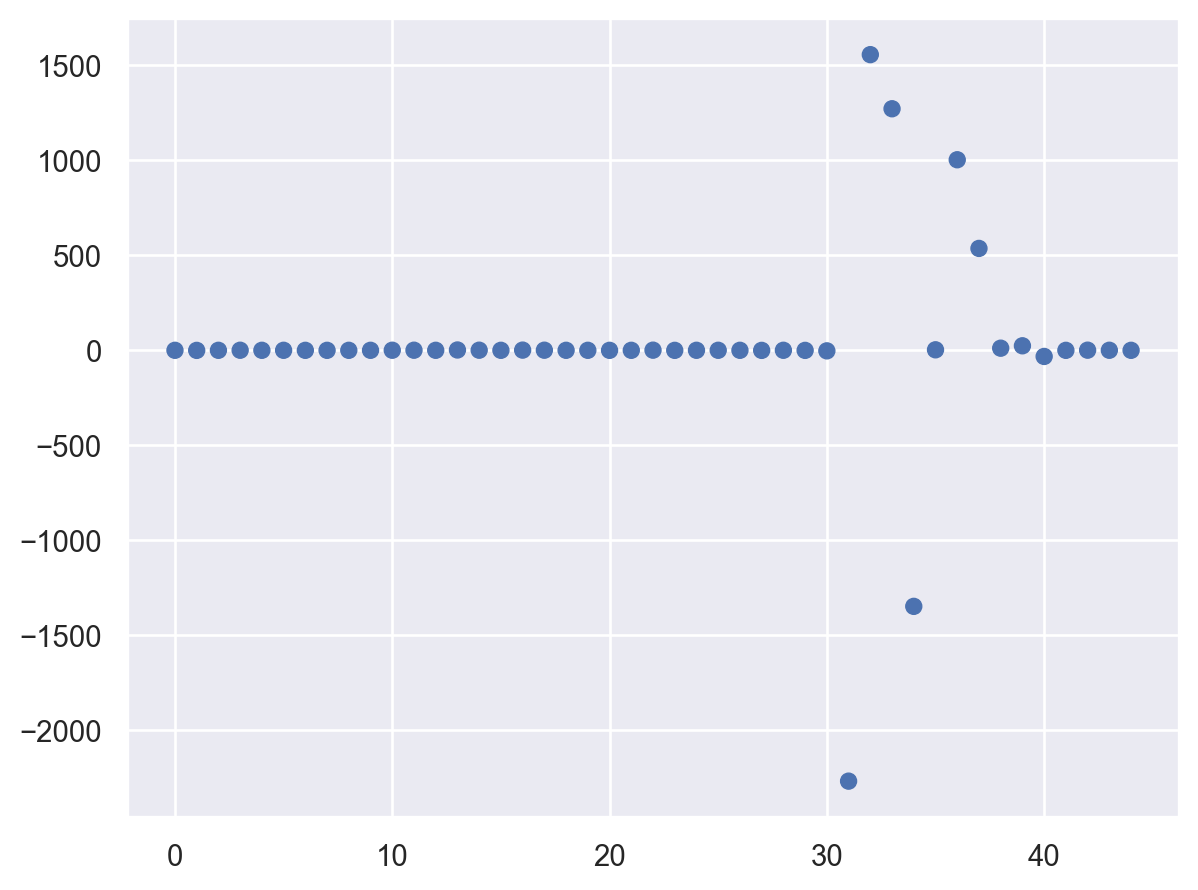

In [65]:
# Graficamos
so.Plot(x = np.arange(len(modeloLineal.coef_)), y = modeloLineal.coef_).add(so.Dot())

Los problemas de colinealidad son más evidentes ahora.

En base a lo observado, vamos a utilizar un modelo de regresión de Ridge.
Separamos en entrenamiento y testeo.

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Inicializamos el modelo lineal
alpha = 1  # Ejercicio: calcular alpha por validacion cruzada
modeloRidge = linear_model.Ridge(alpha = 1)

In [68]:
# Entrenamiento
modeloRidge.fit(X_train, y_train)

# Predicciones
y_pred = modeloRidge.predict(X_train)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53298
R cuadrado: 0.98841


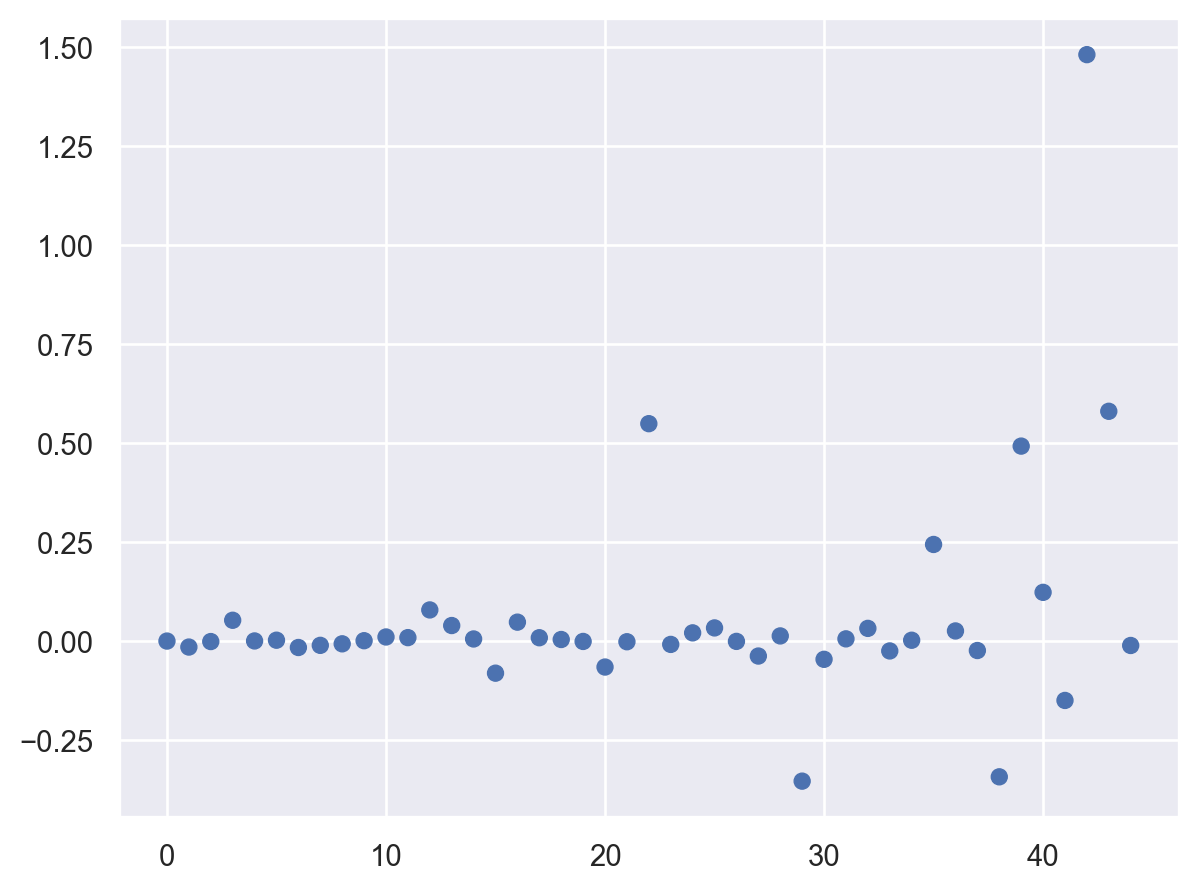

In [69]:
# Observamos los coeficientes
so.Plot(x = np.arange(len(modeloRidge.coef_)), y = modeloRidge.coef_).add(so.Dot())

Redujimos el problema de coeficientes grandes que se anulan, pero todavía resulta difícil comparar los pesos de las distintas variables. 

Además en el modelo lineal Ridge penalizamos coeficientes grandes. Si las variables están a distinta escala, esto hace que penalicemos más a algunas variables que a otras.

En Regresión Ridge casi siempre es necesario escalar las variables.

Reescalamos todas utilizando StandardScaler

Al realizar un escalamiento, no incluimos los datos de testeo, porque suponemos que son datos desconocidos para nosotros.
StandardScaler nos permite calcular la fórmula de escalamiento en un conjunto de datos y aplicarlo en otro.

In [77]:
scaler = StandardScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

In [78]:
# fit_transform calcula los coeficientes de la transformación y la aplica.
X_train_scaled = scaler.fit_transform(X_train)

In [79]:
# Inicializamos el modelo lineal
alpha = 1     # Ejercicio: calcular el alpha optimo por validacion cruzada
modeloRidge = linear_model.Ridge(alpha = alpha)   

# Entrenamiento
modeloRidge.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modeloRidge.predict(X_train_scaled)

# Evaluación
print("alpha = ", alpha)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

print(modeloRidge.coef_)

alpha =  1
Raíz del Error Cuadrático Medio: 0.53298
R cuadrado: 0.98841
[ 7.70547802e-03 -4.01121523e-01 -1.43567218e-02  3.32748290e-01
  2.09136794e-02  5.24652097e-02 -1.47758783e-01 -1.11780570e-01
 -5.76248584e-02  2.11914883e-02  4.03005305e-01  4.62958762e-01
  2.18175998e-02  1.72229181e+00  5.14518049e-01 -1.55935256e-02
  1.02819457e+00  5.26525514e-01  9.24728814e-04 -9.68667952e-04
 -1.36214624e-01 -3.24041568e-02  7.33002883e-01 -2.37727923e-01
  9.63196659e-02  1.27418516e-01 -3.28801688e-03 -3.89535826e-01
  1.56790594e-01 -3.75453526e-01 -2.92104784e+00  5.25503658e-02
  1.69530963e-01 -1.08180857e-01  6.36200910e-02  2.59664551e+00
  1.36120023e-01 -9.33218404e-02 -2.85053185e-01  6.63562740e-01
  3.56712599e-01 -1.74285421e-01  6.96121124e-01  2.40067802e-01
 -5.74732992e-02]


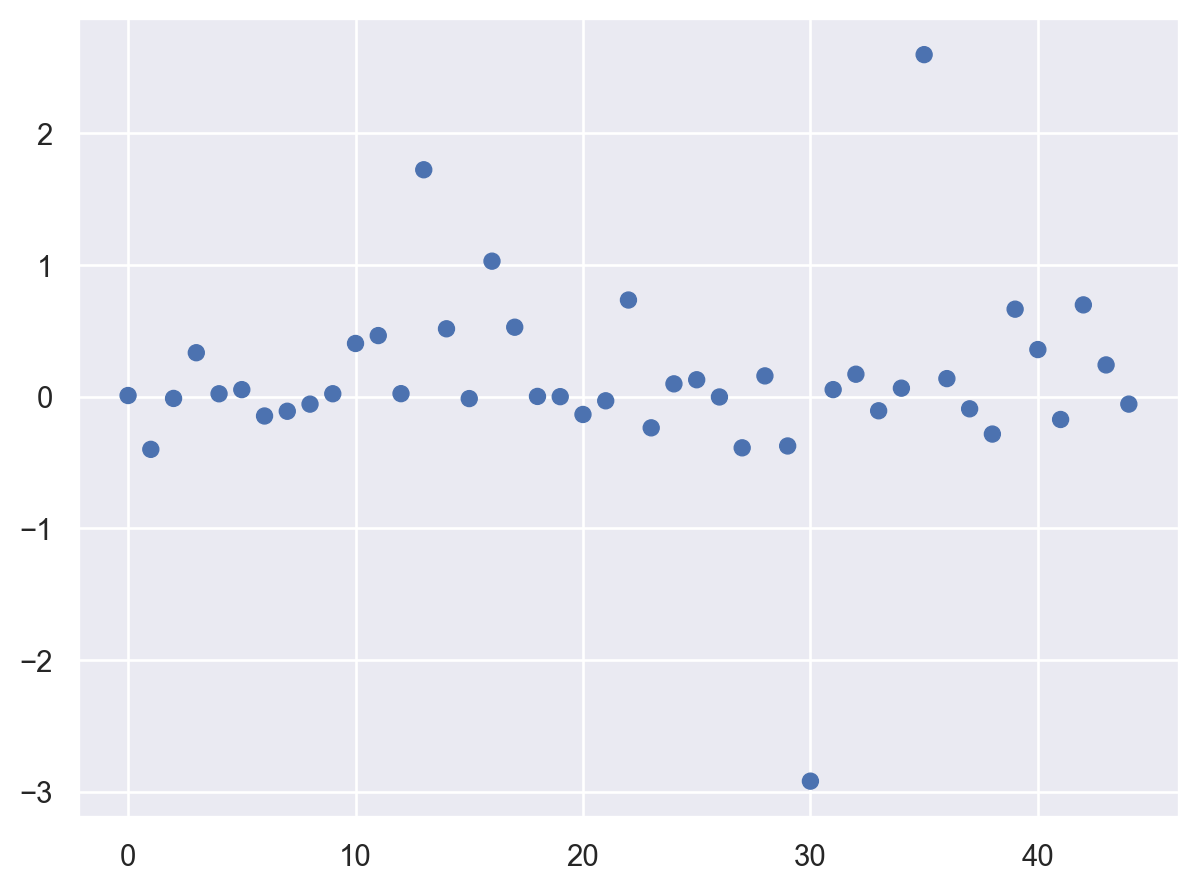

In [80]:
so.Plot(x = np.arange(len(modeloRidge.coef_)), y = modeloRidge.coef_).add(so.Dot())

Ahora queremos ver los resultados en testeo, para eso transformamos los datos de testeo.

In [74]:
# Estará bien hacerlo así?
X_test_scaled = scaler.fit_transform(X_test)

In [75]:
# Predicciones
y_pred = modeloRidge.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53184
R cuadrado: 0.98838


No dio muy mal, porque los parámetros del escalamiento son similares (la media y varianza de una muestra es similar a la media varianza de toda la población), pero es incorrecto

La forma correcta es fittear en entrenamiento y aplicar esa transformación a los datos de testeo:

In [81]:
# Tenemos que fittear en entrenamiento y aplicar esa transformación a los datos de testeo
scaler.fit(X_train)   # Primero fiteamos (este paso no es necesario si ya hicimos fit_transform en X_train)
X_test_scaled = scaler.transform(X_test)  # Luego transformamos

In [82]:
# Predicciones
y_pred = modeloRidge.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.52807
R cuadrado: 0.98854


Vemos que mejoraron las predicciones. 

La diferencia es más notoria si usamos MinMaxScaler.

In [83]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas") # La última opción hace que nos devuelva un DataFrame

In [84]:
# fit_transform calcula los coeficientes de la transformación y la aplica.
X_train_scaled = scaler.fit_transform(X_train)

In [87]:
# Inicializamos el modelo lineal
alpha = 1
modeloRidge = linear_model.Ridge(alpha = alpha) 

# Entrenamiento
modeloRidge.fit(X_train_scaled, y_train)

# Predicciones
y_pred = modeloRidge.predict(X_train_scaled)

# Evaluación en los datos de entrenamiento
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_train, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.54374
R cuadrado: 0.98794


In [86]:
# MAL!

X_test_scaled = scaler.fit_transform(X_test)

# Predicciones
y_pred = modeloRidge.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 1.70927
R cuadrado: 0.87993


In [88]:
print(scaler.data_min_, scaler.data_max_)

[ 1.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00 -3.26219e+00 -3.59144e+01  0.00000e+00
  2.00900e+03  2.00000e+00 -5.43737e+01 -5.56330e+01 -3.14065e-01
  4.83411e-02 -5.62742e+01 -4.21416e+01 -5.74594e+01 -1.25154e+02
  0.00000e+00 -8.28103e+01 -4.23436e+01  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00] [4.10000e+01 9.65000e+01 4.84600e+02 4.99000e+01 1.50000e+02 1.50000e+02
 4.67900e+02 2.05200e+02 1.00000e+02 1.00000e+02 2.56000e+02 3.18000e+02
 1.00000e+00 3.33000e+02 6.78000e+02 1.00000e+00 1.38000e+02 3.94000e+02
 1.00000e+00 1.06500e+02 6.44000e+01 1.00000e+03 8.65819e+00 3.82666e+02
 3.20000e+02 2.02100e+03 7.42000e+04 1.29217e+02 1.40715e+02 5.56188e+00
 3.14136e+02 7.60739e+01 5.83853e+01 5.6

In [89]:
# BIEN

# Tenemos que fittear en entrenamiento y aplicar esa transformación a los datos de testeo
scaler.fit(X_train)   # Primero fiteamos (este paso no es necesario si ya hicimos fit_transform en X_train)
X_test_scaled = scaler.transform(X_test)  # Luego transformamos

# Predicciones
y_pred = modeloRidge.predict(X_test_scaled)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")
r2 = r2_score(y_test, y_pred)
print(f"R cuadrado: {r2:.5f}")

Raíz del Error Cuadrático Medio: 0.53805
R cuadrado: 0.98810


## Ejercicio - Repaso
Seleccionar el alpha óptimo por validación cruzada en X_train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)